In [1]:
# Get the output of Q/K for 4k and 64K before rope and after rope
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.llama.modeling_llama import apply_rotary_pos_emb
from types import MethodType
import json


model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")

# with open("/home/azzhang/streaming-llm/output/wikitext2_prompts_llama3.json", "r", encoding="utf-8") as f:
#     prompts = json.load(f)

# target_length_4k = "2k"

# prompt_4k = prompts[target_length_4k]
# inputs_4k = tokenizer(prompt_4k, return_tensors="pt", add_special_tokens=True).to(model.device)
# seq_len_4 = inputs_4k["input_ids"].shape[1]
# print(seq_len_4)

# input_ids = inputs_4k["input_ids"][0]
# eos_token_id = tokenizer.eos_token_id
# print(tokenizer.eos_token)
# mid = len(input_ids) // 3
# print(mid)
# print(2*mid)
# input_ids_with_eos = torch.cat([
#     input_ids[:mid],
#     torch.tensor([eos_token_id], dtype=torch.long).to(model.device),
#     input_ids[mid:2*mid],
#     torch.tensor([eos_token_id], dtype=torch.long).to(model.device),
#     input_ids[2*mid:]
# ])

# inputs_with_eos = {
#     "input_ids": input_ids_with_eos.unsqueeze(0).to(model.device)
# }
# print(inputs_with_eos["input_ids"].shape[1])
prompt = "Hi! I just wanted to see how everything is going with you. It's been a while since we last talked. I hope you're doing well."
input = tokenizer(prompt, return_tensors="pt", add_special_tokens=False).to(model.device)
seq_length = input["input_ids"].shape[1]
input_ids = input["input_ids"][0]
decoded = tokenizer.convert_ids_to_tokens(input_ids)

# print(decoded)
# print(A)
# print(seq_length)

cache_4k = {}
target_layers = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

def make_patched_forward(layer_idx):
    def patched_forward(self, hidden_states, position_embeddings=None, *args, **kwargs):
        q = self.q_proj(hidden_states)
        k = self.k_proj(hidden_states)
        v = self.v_proj(hidden_states)

        bsz, seqlen, dim = q.shape
        head_dim = self.head_dim
        num_heads_q = self.config.num_attention_heads
        num_heads_kv = self.config.num_key_value_heads

        q = q.view(bsz, seqlen, num_heads_q, head_dim).transpose(1, 2)
        k = k.view(bsz, seqlen, num_heads_kv, head_dim).transpose(1, 2)

        cos, sin = position_embeddings
        q_rope, k_rope = apply_rotary_pos_emb(q, k, cos, sin)

        cache_4k[layer_idx] = {
                "q_raw": q.detach().cpu(),
                "k_raw": k.detach().cpu(),
                "q_rope": q_rope.detach().cpu(),
                "k_rope": k_rope.detach().cpu(),
            }

        return self._orig_forward(hidden_states, position_embeddings, *args, **kwargs)
    
    return patched_forward

for layer_idx in target_layers:
    attn_layer = model.model.layers[layer_idx].self_attn
    attn_layer._orig_forward = attn_layer.forward  # 保存原始 forward
    attn_layer.forward = MethodType(make_patched_forward(layer_idx), attn_layer)


with torch.no_grad():
    outputs = model(**input)
    # outputs = model(**inputs_with_eos)

# torch.save(cache_64k, "/home/azzhang/QK_analysis/cache_64k.pt")


/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azzhang/miniforge3/envs/fms-mo/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


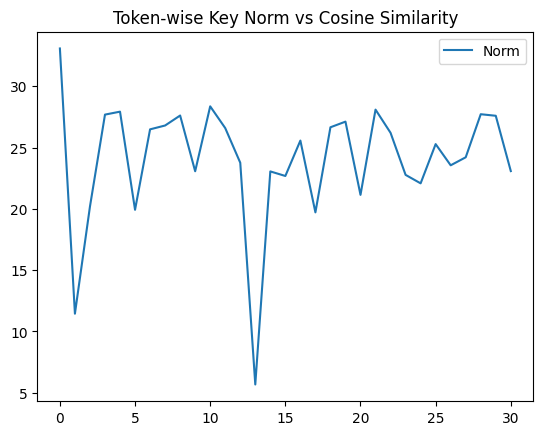

In [ ]:
# compute the L2 norm of K 
import matplotlib.pyplot as plt
import torch.nn.functional as F
target_layer = 1
K_rope = cache_4k[target_layer]["k_rope"].squeeze(0).float() # [num_head, sen_len, head_dim]
K_head = K_rope[1]


k_norm = K_head.norm(dim=-1)  # shape: [seq_len]

# Step 2: 计算 token 两两之间的 cosine similarity 矩阵
cos_sim_matrix = F.cosine_similarity(K_head.unsqueeze(1), K_head.unsqueeze(0), dim=-1)  # shape: [seq_len, seq_len]

# Step 4: 可视化 norm vs avg cosine similarity
plt.plot(k_norm.cpu(), label="Norm")
plt.title("Token-wise Key Norm vs Cosine Similarity")
# plt.grid(True)
plt.legend()
plt.show()

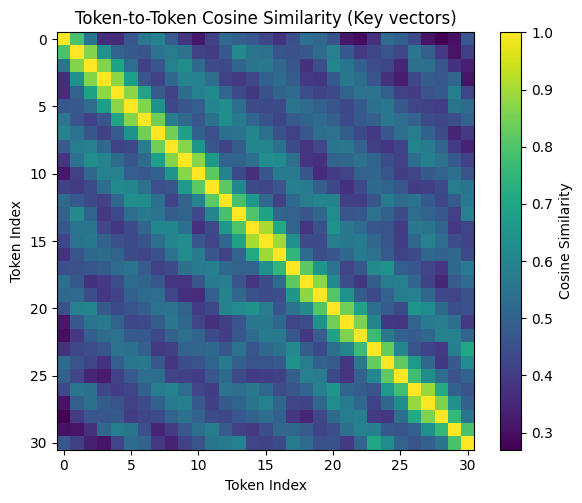

In [12]:
plt.figure(figsize=(6, 5))
plt.imshow(cos_sim_matrix.cpu(), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title("Token-to-Token Cosine Similarity (Key vectors)")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.tight_layout()
plt.show()

torch.Size([1972])


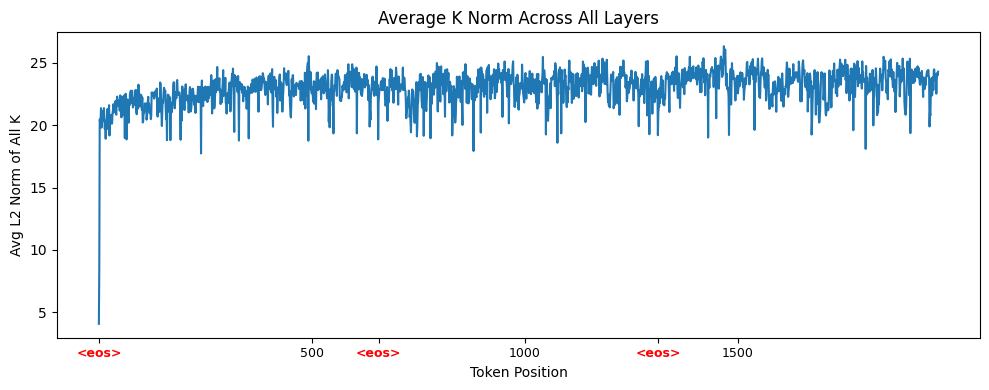

In [4]:
# compute the L2 norm of K 
import matplotlib.pyplot as plt

# layer_id = 2 # choose which layer you want to check
k_norm_mean_all_layers = []
for target_layer in target_layers:

    K_rope = cache_4k[target_layer]["k_rope"].squeeze(0).float() # [num_head, sen_len, head_dim]
    k_norm = K_rope.norm(dim=-1)  # [num_heads, seq_len]
    k_norm_mean = k_norm.mean(dim=0)  # shape: [seq_len]
    k_norm_mean_all_layers.append(k_norm_mean)

K_norm_mean_layers = torch.stack(k_norm_mean_all_layers, dim=0).mean(dim=0)

print(K_norm_mean_layers.shape)

input_ids = inputs_with_eos["input_ids"][0]

# convert string for x label
tokens = [tokenizer.decode([t_id]).strip() for t_id in input_ids]
tokens[0] = "<eos>"
tokens[657] = "<eos>"
tokens[1313] = "<eos>"
x_labels = [""] * len(tokens)
x_labels[0] = tokens[0]
x_labels[657] = tokens[657]
x_labels[1313] = tokens[1313]


tick_step = 500  # 每500个token显示一次tick
tick_positions = list(range(0, len(tokens), tick_step))

# ✅ 合并你想高亮的特殊位置
highlight_token_positions = [0, 657, 1313]
tick_positions = sorted(set(tick_positions + highlight_token_positions))

# ✅ 构建对应的 label（高亮位置显示 token，其它显示数字）
tick_labels = [
    tokens[i] if i in highlight_token_positions else str(i)
    for i in tick_positions
]

plt.figure(figsize=(10, 4))
plt.plot(K_norm_mean_layers.cpu().numpy())
plt.title("Average K Norm Across All Layers")
plt.xlabel("Token Position")
plt.ylabel("Avg L2 Norm of All K")
plt.xticks(
    ticks=tick_positions,
    labels=tick_labels,
    # rotation=45,
    fontsize=9
)
ax = plt.gca()
xtick_labels = ax.get_xticklabels()

for tick, pos in zip(xtick_labels, tick_positions):
    if pos in highlight_token_positions:
        tick.set_color('red')
        tick.set_fontweight('bold')
# plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# compute the L2 norm of K 
import matplotlib.pyplot as plt

layer_id = 2 # choose which layer you want to check
k_norm_mean_all_layers = []
for target_layer in target_layers:

    K_rope = cache_4k[target_layer]["k_rope"].squeeze(0).float() # [num_head, sen_len, head_dim]
    k_norm = K_rope.norm(dim=-1)  # [num_heads, seq_len]
    k_norm_mean = k_norm.mean(dim=0)  # shape: [seq_len]
    k_norm_mean_all_layers.append(k_norm_mean)

K_norm_mean_layers = torch.stack(k_norm_mean_all_layers, dim=0)
print(K_norm_mean_layers.shape)

# input_ids = input["input_ids"][0]

# # convert string for x label
# tokens = [tokenizer.decode([t_id]).strip() for t_id in input_ids]
# tokens[0] = "<bos>"

plt.figure(figsize=(12, 6))
plt.imshow(K_norm_mean_layers.cpu(), aspect='auto', cmap='YlGnBu')
plt.colorbar(label="L2 Norm of K")
# plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(ticks=range(32), labels=[f"{i}" for i in range(32)])
# plt.yticks([])
plt.xlabel("Position Index")
plt.ylabel("Layer Index")
plt.title("K Vector Norm by Position")
plt.tight_layout()
plt.show()

In [ ]:
# attention shape: [num_layers, batch, num_heads, seq_len, seq_len]

head_id = 2 # choose which head you want to check
attn_weights = outputs.attentions[layer_id][0, head_id]  # [seq_len, seq_len]

# token ids
input_ids = input["input_ids"][0]

# convert string for x label
tokens = [tokenizer.decode([t_id]).strip() for t_id in input_ids]
tokens[0] = "<bos>"

attn = attn_weights.detach().cpu().float().numpy()

plt.figure(figsize=(8, 6))
plt.imshow(attn, cmap="YlGnBu", aspect="auto", vmin=0.0, vmax=1.0)
plt.yticks(range(len(tokens)), tokens)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title("Attention Score")
plt.colorbar(label="Attention Score")
plt.tight_layout()
plt.show()

In [ ]:
# obtain attention score and K
attn = outputs.attentions[layer_id][0, head_id].float()  # shape [seq_len, seq_len]
key_vec = cache_4k[layer_id]["k_rope"].squeeze(0).float()      # shape [seq_len, head_dim]

# compute key norm and avg. of attention score 
key_norms = key_vec[1].norm(dim=-1)                # L2 norm of each token in K
attn_mean_received = attn.mean(dim=0).cpu()     # avg. attention score of each token

plt.figure(figsize=(6, 5))
plt.scatter(key_norms, attn_mean_received, alpha=0.7)
plt.xlabel("Key L2 Norm")
plt.ylabel("Avg Attention Received")
plt.title("Negative Correlation Between Key Norm and Attention")
plt.tight_layout()
plt.show()
